# Try with Statsforecast

In [1]:
import random
import time
from multiprocessing import cpu_count, Pool # for prophet
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
data =  pd.read_csv('../../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime').drop(columns=['2657', '2828']) #DROPPING FAULTY SYSTEMS
uk_pv = pd.read_csv('../../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')

data.index = pd.to_datetime(data.index)
# ix = pd.date_range(start=data.index[0], end=data.index[-1], freq='5min')
# data = data #.reindex(ix).fillna(0)

In [3]:
n_train = 100000
n_test = 24
n_series = 10
train = data.iloc[-n_train-n_test: -n_test , :n_series]
test = data.iloc[-n_test: , :n_series]
ts = train.iloc[:,0:1].reset_index().rename(columns = {'datetime':'ds', '2607':'y'})
ts['lag_2h'] = ts['y'].shift(24)
ts = ts.dropna()

In [4]:
#following this to put constant trend: https://github.com/facebook/prophet/issues/614

m = Prophet(growth = 'flat', yearly_seasonality = 10, weekly_seasonality =False, daily_seasonality = 20,
           seasonality_prior_scale = 1, seasonality_mode = 'multiplicative')

m.add_regressor('lag_2h')
m.fit(ts)

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -2045.41
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       88145.4    0.00153346       16.5788           1           1      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [5]:
day_max = 16
day_min = 8
future = m.make_future_dataframe(periods=100, freq = '5min')
future2 = future[(future.ds.dt.hour >= 8)  & (future.ds.dt.hour <= 16) ]
future2 = future2.iloc[:len(ts) + n_test]
future2['lag_2h'] = np.concatenate((ts['lag_2h'].values , test['2607'].values))

In [6]:
forecast = m.predict(future2)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,yhat,yhat_lower,yhat_upper
70542,2019-12-31 15:40:00,-0.077511,-0.291612,0.162530
70543,2019-12-31 15:45:00,-0.084919,-0.338561,0.142423
70544,2019-12-31 15:50:00,-0.091836,-0.355836,0.140216
70545,2019-12-31 15:55:00,-0.099598,-0.343473,0.134952
70546,2019-12-31 16:00:00,-0.108873,-0.338104,0.121233


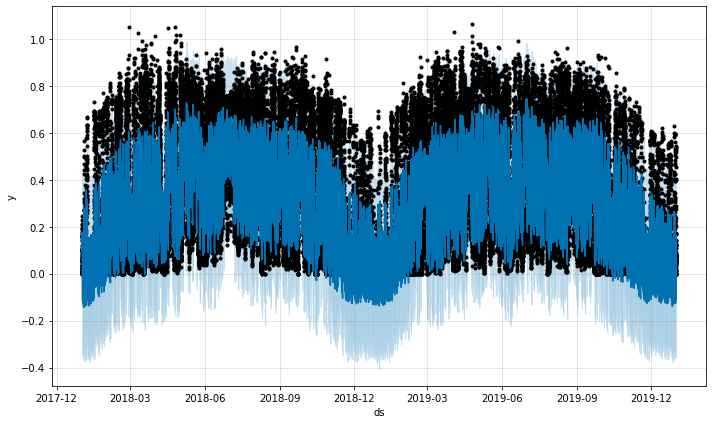

In [7]:
fig1 = m.plot(forecast,)
# plt.xlim(pd.to_datetime('2019-12-31'), pd.to_datetime('2020-01-01'))

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


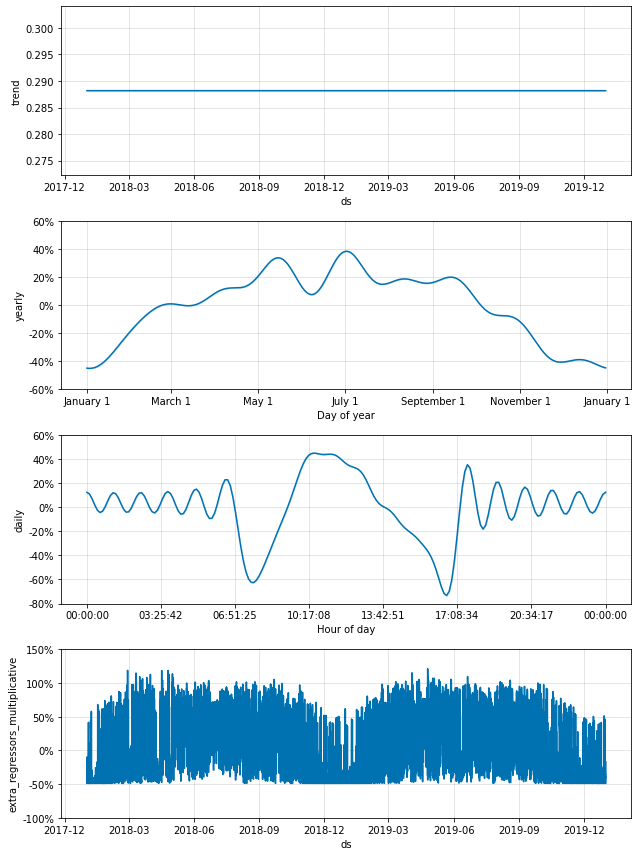

In [8]:
fig2 = m.plot_components(forecast)


In [9]:
from prophet.diagnostics import cross_validation


In [12]:
df_cv = cross_validation(m, initial='100 days', period='3 days,  2 hours', horizon = '2 hours')

INFO:prophet:Making 197 forecasts with cutoffs between 2018-04-13 10:00:00 and 2019-12-31 12:00:00


  0%|          | 0/197 [00:00<?, ?it/s]

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -234.92
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       12434.8     0.0117601       32.5433           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       12437.7    0.00838072       21.4757           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       12440.7     0.0066665       35.6922           1           1      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       12455.4     0.0073266       203.967           1           1      484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       12461.4   0.000666676       71.3516           1           1      592   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -242.378
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       12752.7    0.00220485       8.02719           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       12753.2   0.000352416        5.1732           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       12754.7    0.00857848       57.0923      0.7996      0.7996      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       12759.1    0.00306214       105.904           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       12762.2      0.015575       275.343           1           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -265.497
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       13155.3     0.0334016       106.178      0.7989      0.7989      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       13163.8     0.0154293        156.54           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       13169.7     0.0237593       625.495           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       13177.3     0.0018486       73.3422           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       13182.5    0.00112739       107.067           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -288.353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       13545.3     0.0159259       30.9993      0.8796      0.8796      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       13546.5   0.000283744       8.68769      0.3446           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       13546.9     0.0019081       28.4434           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       13547.9    0.00893408       37.6378           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       13548.2   0.000456575       14.2339           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -296.247
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         13845    0.00373645       54.6398           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       13857.3     0.0121297        33.748           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       13862.2    0.00324663        11.272           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         13865     0.0239363       53.2776           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       13866.9    0.00326439        33.279           1           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -304.302
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       14234.2      0.018989       271.758           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       14243.4    0.00144659       45.5517      0.1843           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       14244.9     0.0168195       56.7133           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       14248.1     0.0222813       43.4518      0.6232      0.6232      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         14249     0.0230608       25.7755           1           1      589   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -313.819
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       14470.6     0.0147201       71.6508           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       14482.8      0.107564       113.905           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       14494.7    0.00977876       67.9329           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       14496.3     0.0231281       62.0841           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       14499.5      0.023984       141.604           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -331.052
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       14798.3     0.0684487       270.331           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       14829.7    0.00107616       42.0332           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       14840.7     0.0322707       225.628           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       14847.8    0.00111751       111.192      0.6657      0.6657      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       14849.2   0.000601642       37.8246           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -355.632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15277.2     0.0951575       196.028           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15293.8     0.0112064       70.1289           1           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       15298.8    0.00095147       77.4214      0.2835      0.2835      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       15300.6     0.0045932       50.6542      0.4869      0.4869      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       15305.8    0.00428661       118.691           1           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -371.309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15515.1      0.111605       167.866       1.724      0.1724      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15528.3     0.0341996       139.678           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       15573.3      0.085543        2546.7           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       15599.2    0.00287318       435.382      0.4588           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       15604.9    0.00124425       555.835           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -381.995
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       15917.8      0.011438       185.396           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       15928.6     0.0190198        93.795           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       15959.1     0.0142866       342.193      0.4145      0.4145      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       15961.3   5.23262e-05       20.6769      0.9817      0.9817      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       15962.3   0.000284881       21.4525      0.6594      0.6594      546   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -400.043
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       16312.2     0.0016292       61.0701           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         16314     0.0085973        40.992           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         16320    0.00929437       42.3963           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       16322.4   0.000347185       14.9972      0.6897      0.6897      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       16323.1    0.00671072       67.4725           1           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -422.271
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       16793.1   0.000678429       10.6381       1.983      0.1983      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       16794.4    0.00827456       26.3985           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       16798.6    0.00597562       28.3523           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         16817   0.000915417       197.254      0.8729      0.8729      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       16820.3   0.000340696       100.224           1           1      558   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -438.418
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17126.8   0.000993978       14.3314           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17128.3     0.0389335       46.4765           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17131.5   0.000908673       20.7675           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       17139.6    0.00553417       67.9289      0.8386      0.8386      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       17144.3   0.000366562       292.587       0.541       0.541      540   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -448.176
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17457.2     0.0027077       33.0277           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17464.4    0.00589701       37.9216           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17468.2      0.035692       183.441      0.5443      0.5443      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       17485.3   0.000172387       34.8575           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       17486.2   0.000452813       20.0356           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -453.523
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       17882.4    0.00290982       44.4793           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       17886.2   0.000248074       15.2176           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       17886.9   0.000223656       7.93325           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       17891.5   0.000503316       41.0513      0.7104      0.7104      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       17892.2   0.000129208       9.24022           1           1      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -459.711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18223.7    0.00500744        48.239           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       18227.7    0.00783662       72.7108           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       18235.9    0.00594477       40.9349        0.92        0.92      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       18237.2    0.00656708       19.9908           1           1      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       18237.5    0.00151836        24.037      0.8651      0.8651      537   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -468.602
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       18634.1    0.00155379       62.6128           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       18637.3     0.0384585        172.02           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       18640.6    0.00372833       12.9174           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       18642.2    0.00404205       41.7404           1           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       18643.2    0.00718752       69.9462           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -475.793
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       19028.9    0.00419988       46.9802           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       19033.3    0.00409184       26.9039      0.3815      0.3815      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       19034.9     0.0143716       61.1678           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       19038.7     0.0894716       250.133           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       19052.2   0.000844834       154.261           1           1      538   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -488.493
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       19378.5     0.0703953       316.083           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       19394.3     0.0251331       126.268           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       19399.1    0.00967585       56.0891           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       19415.3      0.012123       270.179      0.3596           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       19431.1     0.0144167       417.642           1           1      552   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -499.415
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       19719.1      0.144009       746.568           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       19754.4    0.00584094       40.8179           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       19769.3    0.00394566       102.289           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       19778.2    0.00151408       81.1727           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         19779     0.0004828       27.0539           1           1      545   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -508.031
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       20066.8    0.00671783       227.609           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       20095.5     0.0079622       128.765      0.3292      0.3292      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       20098.7     0.0078351       59.3208      0.7499      0.7499      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       20107.2     0.0025412       74.0228      0.7472      0.7472      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       20108.3   0.000256181       55.6767      0.6199      0.6199      575   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -520.718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       20429.8     0.0760084       422.958           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       20436.6    0.00749516       81.7038      0.5688      0.5688      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       20446.5    0.00677864       89.0828           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       20453.6     0.0112268       98.3393           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       20456.4   0.000394989        68.468           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -534.53
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       20900.1    0.00211943       45.0692           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       20923.1    0.00564129       100.446           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       20930.2    0.00261057       62.2019           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       20949.9     0.0532159       491.486           1           1      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       20967.7    0.00196949       259.222      0.4522           1      547   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -550.623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       21372.8     0.0397888       294.025           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       21382.4    0.00341938       31.8965           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       21383.6     0.0233208       200.797           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       21388.5     0.0124492       189.324           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       21390.9     0.0184967       324.675       0.368           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -566.207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       21888.5    0.00493257       173.399           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       21898.4    0.00109871       21.4867           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       21901.8     0.0653771       378.068           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         21904    0.00595837       142.948           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       21904.6   0.000715459        43.159           1           1      544   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -581.009
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       22415.2     0.0112686        54.104      0.8828      0.8828      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       22417.1    0.00233864        32.188           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         22420    0.00902643       82.3042      0.7512      0.7512      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         22423     0.0114814       138.819      0.5264           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       22424.6     0.0105682       41.6042           1           1      537   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -593.39
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       22848.6     0.0141183       131.636           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       22852.2    0.00494396       133.919      0.2424           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       22857.4    0.00877719       64.6113           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         22860     0.0202648       94.4973           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       22861.1    0.00891783       74.4688           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -600.084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       23211.5     0.0052949       100.616           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       23219.4     0.0181525       54.0282           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       23232.3     0.0204768       182.548           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       23236.1     0.0176078       140.879           1           1      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       23238.3     0.0013112       74.3155      0.5055      0.5055      578   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -609.259
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       23521.9   0.000793567       89.6483      0.1574      0.1574      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       23525.6     0.0144519       67.9409           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       23526.6   0.000172829        12.435      0.5577      0.5577      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       23526.9     0.0138605       37.9173           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       23527.6    0.00194049       25.5087           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -617.772
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       23914.4     0.0025175       16.0031           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       23917.4   0.000639804       17.9587           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       23917.7   0.000155195        4.8992           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       23918.3    0.00812417       34.5385           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       23920.3    0.00823288       141.534           1           1      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -622.702
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       24285.3     0.0075403       61.1945           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       24289.6   0.000790697       20.5827           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       24290.6   0.000967147       20.0539           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       24291.7   0.000273654       14.5001           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       24293.2     0.0100289       71.3464           1           1      557   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -632.181
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         24698     0.0136747        72.099           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       24700.6     0.0108985       27.1996           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       24704.1     0.0147178       86.0871           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       24706.6    0.00128553       25.8263      0.8701      0.8701      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       24708.1    0.00751802       79.4778           1           1      549   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -638.804
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       25123.1    0.00444329       161.228      0.4227      0.4227      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         25124    0.00629683       84.9278           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       25125.1    0.00140914       24.3289           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       25126.2    0.00274928       32.4704      0.8815      0.8815      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       25126.4    0.00365709       26.1635           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -647.118
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       25442.8     0.0179933       68.7221           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       25444.1   0.000312174       36.2744      0.5652      0.5652      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       25444.2   0.000260521       5.39739      0.7756      0.7756      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     381       25444.3    0.00012349       2.34915      0.8095      0.8095      445   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -658.377
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       25814.8    0.00240354       217.548      0.7546      0.7546      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         25825    0.00309446       48.3681           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       25825.6    0.00246002       34.2666           1           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       25826.2     0.0117784       138.093           1           1      432   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       25826.8    0.00688099       55.3577           1           1      534   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -668.165
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       26248.3     0.0750918       257.235           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       26253.5   0.000769641       13.4162      0.2993           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       26253.8    0.00158709        20.298           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       26254.1    0.00363344       76.9168           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       26254.5    0.00855198       30.2669      0.4226           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -677.396
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       26643.3   0.000803076       44.7355           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       26645.8     0.0104117       89.1557           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       26647.6     0.0286627       63.1132           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       26649.6    0.00972111       68.8462           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       26658.4    0.00294758       108.621           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -686.416
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       26987.8    0.00580589       69.9527           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       26989.7     0.0219175       47.7173           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       26991.2     0.0101173       69.0072      0.4061           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399         26992    0.00701156        51.799           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       26994.1     0.0109671       111.499           1           1      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -692.29
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       27291.6    0.00128437       59.9115           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         27295    0.00159627       10.6455      0.6276      0.6276      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       27295.3   0.000299818        2.2442           1           1      319   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -697.792
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       27673.4   0.000238915       53.4618       0.434       0.434      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       27674.9     0.0143162       48.1645           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       27675.5     0.0191457       44.7447           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     371       27675.8    0.00013157       3.22179      0.8402      0.8402      417   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -702.925
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       28037.4    0.00121154       23.0043           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         28039    0.00357059       33.4015           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         28040    0.00498578       54.8251           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       28040.2    0.00143711       14.2315           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       28040.3   8.45794e-05       4.73925           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -712.977
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       28346.8   0.000499778       17.3545           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       28347.8    0.00136058       20.8927      0.8076      0.8076      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       28347.9     0.0157336        64.006           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       28348.2    0.00254603        31.924       0.949       0.949      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       28348.8   0.000440149       21.5882           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -718.019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       28715.1     0.0223532       414.301           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       28740.1    0.00163019       55.8606           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       28740.6    0.00217791       33.3588           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       28741.5      0.033341       58.1804           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       28744.2    0.00328062       45.4278           1           1      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -724.673
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       29119.3    0.00220211       411.853      0.6053      0.6053      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       29124.7   0.000837591       13.2396           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       29125.7     0.0146997       220.332           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       29126.6    0.00419342       56.6141      0.3244           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       29128.6    0.00459298       64.0953           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -735.334
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       29604.1    0.00184985       30.6732      0.8963      0.8963      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       29606.2    0.00303437       40.9919           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       29607.5   0.000454826       17.2861           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       29609.5    0.00207875       33.0207           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       29611.2    0.00504785       74.7486           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -741.496
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       29897.9    0.00426476       68.7096           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       29899.2    0.00210094       27.7179           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       29900.9     0.0129813       104.158           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       29902.2    0.00508341       49.9313           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     457       29902.4   9.93897e-05         2.733      0.9219      0.9219      510   
Optimization terminated normally: 
  Convergence detected: relat

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -747.323
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         30262    0.00031469       17.7425      0.7353      0.7353      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30266.1     0.0212408       74.4103           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30266.5    0.00439312        80.192       0.503           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       30266.7    9.1208e-05       3.82765           1           1      397   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -755.392
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30652.5      0.131256       322.331           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30666.6    0.00128918       65.3426           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30667.2    0.00194563       38.0233           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       30670.6     0.0211122       188.393           1           1      439   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       30672.8   0.000908654       105.444           1           1      544   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -761.355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       30952.2     0.0302328       185.584           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       30989.4   0.000934466       15.9278           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       30990.5   0.000375243       9.56862       2.237      0.2237      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       30991.2    0.00930161       108.194           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       30992.1   0.000824054       29.7955           1           1      548   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -769.215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         31306    0.00776237       166.128           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       31319.1   9.63588e-05       12.9479      0.7675      0.7675      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         31321     0.0617793        193.45           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       31322.5    0.00156096       19.8419           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       31322.8   0.000623759        13.397           1           1      540   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -777.458
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       31670.6    0.00568416       109.366           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       31676.9     0.0568082       68.2238           1           1      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       31687.3     0.0180009       160.558           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       31698.1    0.00327143       49.4775           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       31702.1    0.00125628       65.4377           1           1      559   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -792.024
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       32094.8   0.000753178       23.9053           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       32095.9     0.0146275       119.925      0.4257           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       32098.1    0.00997979        29.556           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       32098.5   0.000179835       7.29962      0.9025      0.9025      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       32098.7    0.00174807       22.6881           1           1      541   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -804.981
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       32543.4    0.00165264       120.325      0.4746           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       32558.2     0.0139307       107.436           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       32562.2     0.0654571        260.34           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       32564.8    0.00794767       67.3595      0.5617           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       32566.1    0.00557564       43.5177           1           1      565   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -813.46
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       32729.4    0.00773036       96.5376           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       32794.6     0.0138229       542.374      0.9098      0.9098      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         32803     0.0114408       183.919           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       32803.6     0.0213189       111.943           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       32806.5     0.0104742       164.808           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha   

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -822.053
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       33082.3      0.139495       362.256           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       33154.1   0.000780427        49.819           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       33154.8   0.000607222       37.7333      0.2813      0.2813      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       33155.3    0.00262577       40.5437           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         33156   0.000445894       22.6156      0.4705      0.4705      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -830.599
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       33341.8    0.00316632       73.7381           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       33348.4    0.00309377       79.9323           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       33360.4     0.0853024       643.843           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       33392.8    0.00149313       288.978           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       33404.6     0.0100023       651.857           1           1      562   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -840.025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       33735.5     0.0117728       167.743      0.2332           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       33744.5   0.000926938        102.88           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       33772.4    0.00651002       271.834       0.467           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       33798.6   0.000467221       174.768           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       33799.1   5.21114e-05       41.3568      0.9255      0.9255      554   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -852.189
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       34167.6    0.00589033       54.2389           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       34172.1     0.0442035       202.769           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       34179.8      0.021714        164.04      0.9873      0.9873      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       34184.4    0.00228473       84.9179           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       34188.4    0.00053692       42.7453           1           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -858.867
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       34517.2    0.00640344       108.662           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       34553.1    0.00251451        389.07      0.7156      0.7156      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         34562    0.00244213       306.412      0.3909      0.3909      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       34562.6   0.000795404       45.6548           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       34563.2    0.00226205       51.9685           1           1      555   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -867.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       34830.2     0.0422217       451.179           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       34862.5      0.110076       1769.77      0.4695           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       34898.6   0.000146474       46.2734           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       34898.9   0.000470265       39.8436           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       34899.5     0.0201102       169.541           1           1      551   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -876.243
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       35211.4     0.0016118        65.224           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       35220.8     0.0144711       91.6311           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       35221.6    0.00250357       45.0831           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       35222.8    0.00174376       27.6302           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     430       35222.8   2.42408e-05       2.91189           1           1      482   
Optimization terminated normally: 
  Convergence detected: relat

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -886.939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       35455.4    0.00467945       72.3657      0.8367     0.08367      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       35457.7    0.00256254       39.5479           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       35457.8    7.5664e-05       4.12404      0.8406      0.8406      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -897.511
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       35783.5    0.00577179        297.38           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       35794.8     0.0105426       70.3731           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       35795.7    0.00141977       37.4375           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       35796.5    0.00132012       25.0701      0.6166      0.6166      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       35796.7    0.00189281       17.3367     0.09072           1      596   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -907.631
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       36112.3     0.0248016       170.911           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         36115    0.00631704       50.9411           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         36116     0.0011192       25.1237      0.9172     0.09172      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       36116.4    0.00192561       27.2183           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       36117.3   0.000628225       19.6722           1           1      600   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -916.948
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       36574.1    0.00410977       593.927      0.2534      0.2534      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       36575.9   0.000753524       38.6282           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       36576.4   0.000611876       34.7099           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       36577.3     0.0149979       17.8409           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       36578.2     0.0124843       24.1832           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -925.974
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       36911.9   0.000319617       43.5401      0.3011      0.3011      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161         36912   0.000116349       7.12037      0.5002           1      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -934.985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       37220.9   0.000587707       38.1578      0.4402           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         37221   0.000819732       21.6671     0.07127           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       37221.1    0.00254471       2.82493           1           1      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -945.595
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       37648.8   0.000151481       6.21388           1           1      117   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -953.462
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       38027.3    0.00106594       7.49336           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       38027.4   0.000161662       5.29195      0.3078           1      214   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -965.703
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         38533    0.00169751       15.2326           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       38533.2    0.00277547       20.5623      0.6501      0.6501      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       38533.2    0.00015671       3.34604      0.9983      0.9983      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -977.882
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       38980.7   0.000420717        11.491       1.457      0.1457      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       38980.9   0.000180003       13.2331     0.06308           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       38980.9    0.00226974        4.6099           1           1      259   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -990.601
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       39480.4   0.000272418       13.3648           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       39480.6   7.22488e-05       4.17305           1           1      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1000.94
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       39930.6    0.00189778       24.3715           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       39930.8   0.000106916       4.12877           1           1      201   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1011.21
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       40359.7    0.00778741       63.7395           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       40359.8   2.96127e-05       8.81847      0.4654      0.4654      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1022.31
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       40844.1    0.00177803       12.4445           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       40844.2   0.000215807         6.057           1           1      151   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1030.55
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       41334.8   6.19882e-05       5.12958       0.924       0.924       65   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1040.4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       41820.2    0.00115669       13.9804      0.2819      0.8351      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       41820.2   0.000507963       5.23359           1           1      167   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1050.08
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40       42319.7   5.17739e-05       10.4694      0.2734      0.9738       54   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1058.77
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       42723.4    0.00107974       9.21445      0.4238      0.4238      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       42723.4   0.000149963       1.82281           1           1      154   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1068.6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       43230.7   5.35534e-05       4.29304      0.3514           1       67   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1080.22
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       43749.7   0.000105991       4.94378           1           1       68   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1090.33
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       44261.2   0.000118044       4.54837      0.4877           1       80   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1099.93
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       44776.7   0.000126862       4.91971           1           1       70   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1109.89
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       45266.9   7.70216e-05       5.33675           1           1       69   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1118.2
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       45732.6   0.000638791       17.5989           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       45732.7   0.000346928       6.37775           1           1      198   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1128.13
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       46262.9    0.00209854       13.4268           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121         46263   0.000231498       8.11821       0.183      0.8369      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1137.39
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       46714.7   0.000511131       5.31034      0.7267      0.7267      103   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1145.99
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       47171.3   0.000672546       28.5984      0.8037      0.8037      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       47171.3   9.14369e-05       9.05819      0.2655           1      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1153.17
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       47515.3   0.000131523       4.44164           1           1       72   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1160.02
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       48009.5    0.00010479         10.56      0.6656      0.6656       58   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1166.53
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       48449.3   6.26655e-05        4.9996     0.07668      0.9425       62   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1175.46
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       48819.5   2.67853e-05       9.53695       0.482           1       65   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1183.52
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       49208.9    0.00237977       27.5079           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180         49209   0.000929693       6.56424      0.9325      0.9325      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1188.72
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       49616.9   0.000448284       10.0777           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134         49617   0.000878437       4.76903           1           1      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1195.91
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       50040.9     0.0001486       8.06162           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       50040.9   9.83359e-05       7.87292      0.4397           1      131   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       50439.6   0.000194149       4.47375           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       50439.6   0.000674059       9.78948           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       50439.6   0.000268079       4.56763      0.6327      0.6327      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1215.05
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       50798.2   0.000595889       14.1606           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       50798.2   0.000483861         5.427      0.1442           1      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1223.39
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       51158.2   0.000440067       6.82421           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       51158.4   0.000487068       5.01434      0.1031           1      230   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1233.99
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       51435.4    0.00123475       25.7922           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       51435.7   0.000415133       7.62065           1           1      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1248.1
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       51840.5   0.000953301       26.1588           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       51840.7   0.000947069       12.9846           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       51840.7   0.000409134       7.70236           1           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1256.29
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       52227.3    0.00174375       31.4786           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       52227.3   0.000461796       9.48915           1           1      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1265.88
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       52524.7   0.000702721       17.5126      0.6335      0.6335      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173         52525   0.000235669       6.71326           1           1      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1270.77
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       52898.2    0.00108252       65.9483     0.06804           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       52898.4   4.38405e-05       4.55345      0.1735           1      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1285.15
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       53090.9    0.00767831       79.9582       2.933      0.2933      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       53091.1   0.000950986       2.48859           1           1      230   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1294.14
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         53357    0.00104392       25.2534           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       53357.1    0.00140627       7.81455           1           1      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1302.54
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       53669.6   0.000751518       19.9616      0.7818      0.7818      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       53669.6   8.55429e-05       2.99366           1           1      158   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1310.56
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       53990.6    0.00112714       43.3335        0.26           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       53990.7    0.00124102       4.02299           1           1      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       54312.5   0.000724732       22.3054      0.1339      0.7008      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       54312.5    0.00244268       3.07479           1           1      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1331.45
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       54641.7    0.00393364       23.7542           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       54641.8    0.00119855       7.05221           1           1      161   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1346.77
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       54987.4   0.000581301       32.1896      0.2534           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       54987.7   0.000708333        4.8855      0.9406      0.9406      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1357.52
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       55223.9   6.87274e-05       9.00376     0.08097           1       62   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1363.98
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       55545.9   0.000456015       26.2732           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       55546.2    0.00207253        15.351      0.9837      0.9837      174   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1371.79
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       55974.2     0.0130652       67.8729           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       55974.5    0.00111968       69.7522      0.2102      0.2102      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       55974.5    0.00214776       10.8064      0.8775      0.8775      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1383.94
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       56207.7    0.00209449       14.1789           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133         56208    0.00145179       7.77646           1           1      161   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1394.98
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       56462.9    0.00366122        16.049      0.9473      0.9473      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       56463.2   0.000279744       8.07671      0.3607      0.8496      214   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1406.08
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         56848    0.00035643       10.3493       0.892       0.892      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       56848.3   0.000987622        13.781           1           1      184   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1424.24
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       57288.2   0.000759493       18.8675           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       57288.4    0.00472554       20.4957       1.327      0.1327      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       57288.4   0.000394898       3.38364           1           1      247   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1393.26
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       58287.7     0.0119568       101.971           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       58287.9   0.000807424       8.10127           1           1      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1399.97
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       58639.1   9.16905e-05       19.1121           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       58639.3   0.000282178       7.25469       0.747       0.747      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1406.3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         58989   0.000418038       123.335      0.3965           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       58989.1   0.000827944       3.79958           1           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1415.35
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      38       59201.6   0.000135736       4.68946           1           1       54   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1420.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       59469.9    0.00756307       26.0065           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151         59470   0.000942524       9.31204      0.2089      0.9528      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1428.86
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       59741.8   8.85503e-05       7.28232           1           1       60   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1447.33
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       60128.9    0.00488635       53.8672           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       60129.1   0.000706444       8.29172           1           1      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1459.52
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       60531.9    8.4043e-05       8.58289           1           1       72   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1466.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       60886.6    0.00156679       33.4591      0.4348           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       60886.9   3.19249e-05       10.7018           1           1      185   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1480.76
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       61255.9   0.000129571       6.80729           1           1       69   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1488.7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       61616.6    0.00129104       20.4983           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       61616.7   0.000272247       10.6838      0.7765      0.7765      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1493.57
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       61914.7    0.00135114       11.9475           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       61914.8   0.000237962       8.10062       0.284           1      179   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1500.68
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       62245.2   0.000517964       16.7475           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       62245.3   0.000319978       10.6479           1           1      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1509.27
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       62573.4   0.000136307       7.21731      0.3824           1       63   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1517.85
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       62908.6   0.000287017       15.3749      0.9609      0.9609      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       62908.8   0.000593886       8.65552      0.2982      0.9892      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1525.05
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       63293.5   0.000308799       6.85309           1           1      103   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1529.53
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       63627.2   8.97606e-05       6.21692      0.3079           1       71   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1535.07
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       64016.8   0.000842868        33.361      0.2066           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175         64017   0.000222379       6.32715           1           1      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1543.21
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       64321.8   0.000177383       20.0912           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159         64322   3.69284e-05        9.3207           1           1      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1549.65
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       64596.9   0.000194789       9.96504           1           1      122   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1561.22
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88         65044    0.00117237       5.02559           1           1      112   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1572.67
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48         65399   6.57202e-05       11.7396           1           1       61   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1582.47
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       65798.1   0.000159167       7.91615           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       65798.3   3.44911e-05       6.10897           1           1      182   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1592.71
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       66124.1   0.000582071       7.44302           1           1      120   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1598.59
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       66508.5    0.00178733        16.758       0.611       0.611      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       66508.5   0.000425663       7.23622           1           1      125   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1603.41
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       66859.9   0.000329376       11.3188           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       66860.1   0.000523033       6.37153       0.916      0.0916      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1607.92
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       67224.1   0.000229412       14.5396           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       67224.3   0.000817139       5.62206           1           1      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1614.72
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80         67578   0.000625664       10.0848           1           1      100   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1623.93
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       68000.3   0.000111172       9.38637           1           1       73   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1632.39
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       68370.6        0.0235       99.4503           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       68370.8   0.000565932        8.4309      0.3573           1      151   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1642.02
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       68711.7   0.000162412       13.1846      0.5755      0.5755       94   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1645.84
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80         69032   5.76929e-05        8.4291           1           1      107   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1651.54
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       69417.9    0.00224645       23.2026      0.3394           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       69418.2   0.000410299       12.0821        1.08       0.108      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1659.55
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       69745.5    0.00119388       24.9752           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       69745.6   0.000317932       12.1729      0.5039           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1667.26
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       70085.1   0.000170279       16.7701           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       70085.5   0.000782451       4.93448      0.2914           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1675.51
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       70411.1    0.00155225       23.0023      0.2767           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       70411.4    5.8431e-05       8.07351       0.904       0.904      182   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1684.73
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93         70668    0.00019692       12.9067           1           1      120   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1693.48
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       70988.2    0.00136315       89.9117      0.4925      0.4925      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       70988.2   0.000182405       7.39399           1           1      146   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1704.26
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       71400.8    0.00313683       61.0301           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       71401.1   0.000320704       7.56569       1.099      0.1099      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1715.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         71844   0.000438918       40.6596      0.1372      0.1372      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       71844.3   0.000240067        5.2959      0.8453      0.8453      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1720.69
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90         72243   0.000160761       12.4621      0.5541      0.5541      109   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1730.85
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       72551.1   0.000664187       7.31275      0.9516      0.9516      107   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1740.59
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       72903.8   0.000492909       33.9585      0.5903      0.5903      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       72903.8    0.00115902       8.90231           1           1      120   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1746.71
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       73249.5   0.000187944       23.3799           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       73249.9   0.000352505       4.91639           1           1      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1756.16
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       73577.6     0.0116247       78.5442           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       73577.9   0.000410728       5.53143      0.4723           1      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1765.88
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       73989.1   0.000313379       24.1373           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       73989.5   0.000370436       11.3383           1           1      220   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1776.57
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       74368.7   7.75082e-05       11.5855           1           1       63   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1787.37
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       74720.1   0.000171421       34.3253      0.3365      0.3365      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       74720.3   0.000476529       7.97991           1           1      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1795.64
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       75049.2   0.000840619       36.3456           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       75049.6    0.00138642       8.61744      0.8584      0.8584      184   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1801.43
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       75389.5    0.00523442       112.078      0.2289           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150         75390    0.00100261        8.7656           1           1      177   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1811.43
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       75712.6   7.90996e-05       8.88818           1           1       57   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1816.64
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41       76049.1   0.000228872       13.5308           1           1       55   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1823.8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       76461.6    0.00299481       60.4567      0.1734           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185         76462   0.000433325       6.41925      0.2244           1      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1829.95
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       76888.6   0.000113389       12.9324           1           1       56   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1839.18
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         77327    0.00342273        58.776           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       77327.5   0.000219415        20.065      0.1233           1      185   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1846.65
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50         77680   0.000216893        11.731           1           1       65   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1853.04
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       78045.7    0.00338531       30.7068           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       78046.1   0.000154958       15.7759           1           1      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1862.53
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       78434.4    0.00251017       36.8883           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       78434.7   0.000121602       6.81489      0.1084      0.9584      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1873.02
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       78815.9    0.00392455       29.2151           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       78816.3    0.00178068       4.79984           1           1      234   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1878.77
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       79217.4    0.00304379       76.8876      0.3512      0.3512      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       79217.6   3.72779e-05       19.4218      0.2939           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1887.65
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       79651.7   0.000142281       9.53517           1           1       68   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1895.87
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       80025.1   0.000216748        17.181           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       80025.3   0.000117302       12.4906           1           1      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1903.66
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       80495.1     0.0116639       111.596           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       80495.6    0.00023777       4.83065           1           1      203   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1911.4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       80900.9    0.00415473        51.122           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       80901.2   0.000507906       10.5848           1           1      169   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1920.96
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       81377.6    0.00411354       42.3841           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       81377.8    0.00195579       10.1065           1           1      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1929.26
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       81812.2    0.00483643        43.986           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       81812.5   0.000331677       10.6582      0.9634      0.9634      206   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1936.27
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       82293.2   0.000572556         67.97     0.09698           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       82293.5    0.00951775        105.74           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       82293.6    0.00021505       4.94554      0.9459      0.9459      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1948.15
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       82810.7    0.00102933       29.4582      0.6828      0.6828      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       82810.9   0.000233657       7.38756           1           1      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1957.72
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       83314.6    0.00243895       53.5762           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       83314.8    0.00109556       15.1646           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       83314.8   0.000112044         8.483           1           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1965.42
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       83749.7   0.000623897       37.7572      0.3665      0.3665      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149         83750   0.000585715       14.2378           1           1      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1973.61
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       84245.1   0.000955655       45.1793           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       84245.4   0.000228741       18.9566      0.3839       0.793      174   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1980.71
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       84714.8   0.000132326       11.9359      0.5911      0.5911       72   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1989.79
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       85193.2   0.000101099        16.372           1           1       66   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -1999.35
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       85670.7   0.000686894       11.2702      0.2714           1      120   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -2009.03
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       86182.6   6.69287e-05       11.5977      0.3219           1       66   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -2019.34
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       86686.4   0.000180619       10.1149           1           1       75   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -2026.36
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       87132.3    0.00840925       39.3629           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       87132.3    0.00150631       6.46329           1           1      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -2037.04
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       87632.5   7.16852e-05       13.6248     0.08495           1      107   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -2045.04
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       88121.4    0.00102328        38.877           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       88121.4    0.00103525       18.1103           1           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/SeanNassimiha/prophet/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [13]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-04-13 10:05:00,0.055386,-0.178311,0.291159,0.117793,2018-04-13 10:00:00
1,2018-04-13 10:10:00,0.062397,-0.173591,0.287939,0.115769,2018-04-13 10:00:00
2,2018-04-13 10:15:00,0.073292,-0.156585,0.303588,0.087568,2018-04-13 10:00:00
3,2018-04-13 10:20:00,0.081070,-0.141990,0.324696,0.091209,2018-04-13 10:00:00
4,2018-04-13 10:25:00,0.085644,-0.150580,0.315176,0.121640,2018-04-13 10:00:00
...,...,...,...,...,...,...
3808,2019-12-31 13:40:00,0.085518,-0.164111,0.304473,0.086099,2019-12-31 12:00:00
3809,2019-12-31 13:45:00,0.094840,-0.158124,0.319467,0.080031,2019-12-31 12:00:00
3810,2019-12-31 13:50:00,0.095702,-0.143482,0.342448,0.077091,2019-12-31 12:00:00
3811,2019-12-31 13:55:00,0.090081,-0.145246,0.317994,0.075922,2019-12-31 12:00:00


In [14]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,0 days 00:15:00,0.036131,0.190083,0.152087,0.502576,0.681453,0.780046
1,0 days 00:20:00,0.035426,0.188219,0.150389,0.480270,0.676293,0.772590
2,0 days 00:25:00,0.033444,0.182877,0.146092,0.468568,0.656439,0.780430
3,0 days 00:30:00,0.032146,0.179292,0.143264,0.425042,0.632640,0.786833
4,0 days 00:35:00,0.034633,0.186099,0.145636,0.412524,0.627411,0.788304


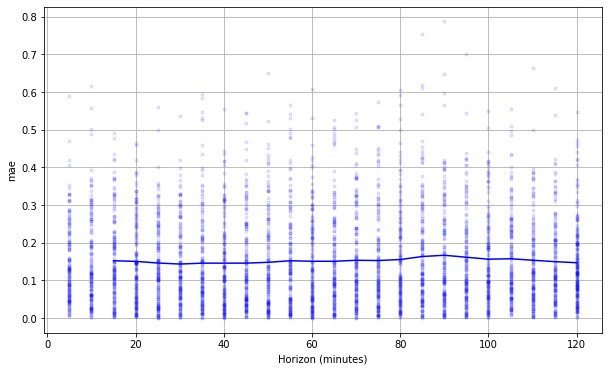

In [15]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')
